# Прогноз вероятности снижения покупательской активности и разработка персонализированных предложений

Описание проекта: интернет-магазин "В один клик" терпит кризис: старые клиенты отворачиваются от него, а привлекать новых бесполезно, ведь целевая аудитория и так о нем знает. В это нелегкое время только модели машинного обучения могут спасти интернет-магазин от банкротства путем персонализированных предложений клиентам, которые и предстоит составить в проекте.
    
Цель исследования: используя модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
    
Ход исследования:

    Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов
    
    Предобработка данных: обработка пропущенных значений, удаление дубликатов и т.д.
    
    Исследовательский анализ данных: статистический анализ всех признаков
    
    Корреляционный анализ данных: рассчитать коэффициенты корреляции для всех признаков
    
    Использование пайплайнов: обучение четырех моделей и выбор лучшей из них по выбранной метрике
    
    Анализ важности признаков: оценка важности признаков с помощью метода SHAP
    
    Сегментация покупателей: графическое и аналитическое исследование группы покупателей
    
    
Общий вывод: резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

## Загрузка данных


In [1]:
import re
import sys
import pandas as pd
import numpy as np
!pip install matplotlib==3.7.3
!pip install --upgrade shap
import matplotlib.pyplot as plt
!"{sys.executable}" -m pip install phik -q
!pip install -U scikit-learn
import shap
import phik
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import(
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler,
    MinMaxScaler,
    LabelEncoder
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    GridSearchCV
)

In [2]:
file=pd.read_csv('/datasets/market_file.csv')
display(file)
market_money=pd.read_csv('/datasets/market_money.csv')
display(market_money)
time=pd.read_csv('/datasets/market_time.csv')
display(time)
money=pd.read_csv('/datasets/money.csv')
display(money)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
...,...,...,...
2595,216645,текущий_месяц,18
2596,216646,предыдцщий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10


,id;Прибыль
215348;0,98.0
215349;4,16.0
215350;3,13.0
215351;4,87.0
215352;4,21.0
...,...
216643;4,44.0
216644;6,11.0
216645;3,29.0
216646;4,3.0


## Предобработка данных

В таблице time в столбце "Период" можно заметить ошибку в значении:"предыдцщий месяц"

In [3]:
time['Период']=time['Период'].replace('предыдцщий_месяц','предыдущий_месяц')
display(time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
...,...,...,...
2595,216645,текущий_месяц,18
2596,216646,предыдущий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10


In [4]:
display(file.info())
display(market_money.info())
display(time.info())
display(money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348;0 to 216647;3
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id;Прибыль  1284 non-null   float64
dtypes: float64(1)
memory usage: 20.3+ KB


None

В данных не обнаружено пропусков, проверю на наличие дубликатов.

In [5]:
display(file.duplicated().sum())
display(market_money.duplicated().sum())
display(time.duplicated().sum())
money.duplicated().sum()

0

0

0

1209

Дубликатов также не обнаружено

Замечу, что в датасете money столбцы id и прибыль склеились, и их стоит разделить

In [6]:
money=pd.read_csv('/datasets/money.csv',sep = ';', decimal = ',')
print(money.info())
money

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
...,...,...
1295,216643,4.44
1296,216644,6.11
1297,216645,3.29
1298,216646,4.03



Теперь приведу все названия столбцов к змеиному виду

In [7]:
file.columns = [i.lower() for i in file.columns]
file=file.rename(columns={'покупательская активность':'покупательская_активность','тип сервиса':'тип_сервиса','разрешить сообщать':'разрешить_сообщать'})
file

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


## Исследовательский анализ данных

В таблице money исследую клиентов, от которых не было выручки.

In [8]:
market_money.query("Выручка==0")

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [9]:
len(market_money['id'].unique())

1300

Можно заметить,что клиентов с нулевой клиентской активностью в течение трех месяцев нет, есть три человека, которые судя по всему являются новыми пользователями и только в этом месяце совершили первую покупку

In [10]:
active_users=(market_money[market_money['Выручка']!=0]['id'])
file[file['id'].isin(active_users)]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


Изменю значение "стандартт"

In [11]:
file['тип_сервиса']=file['тип_сервиса'].replace('стандартт','стандарт')

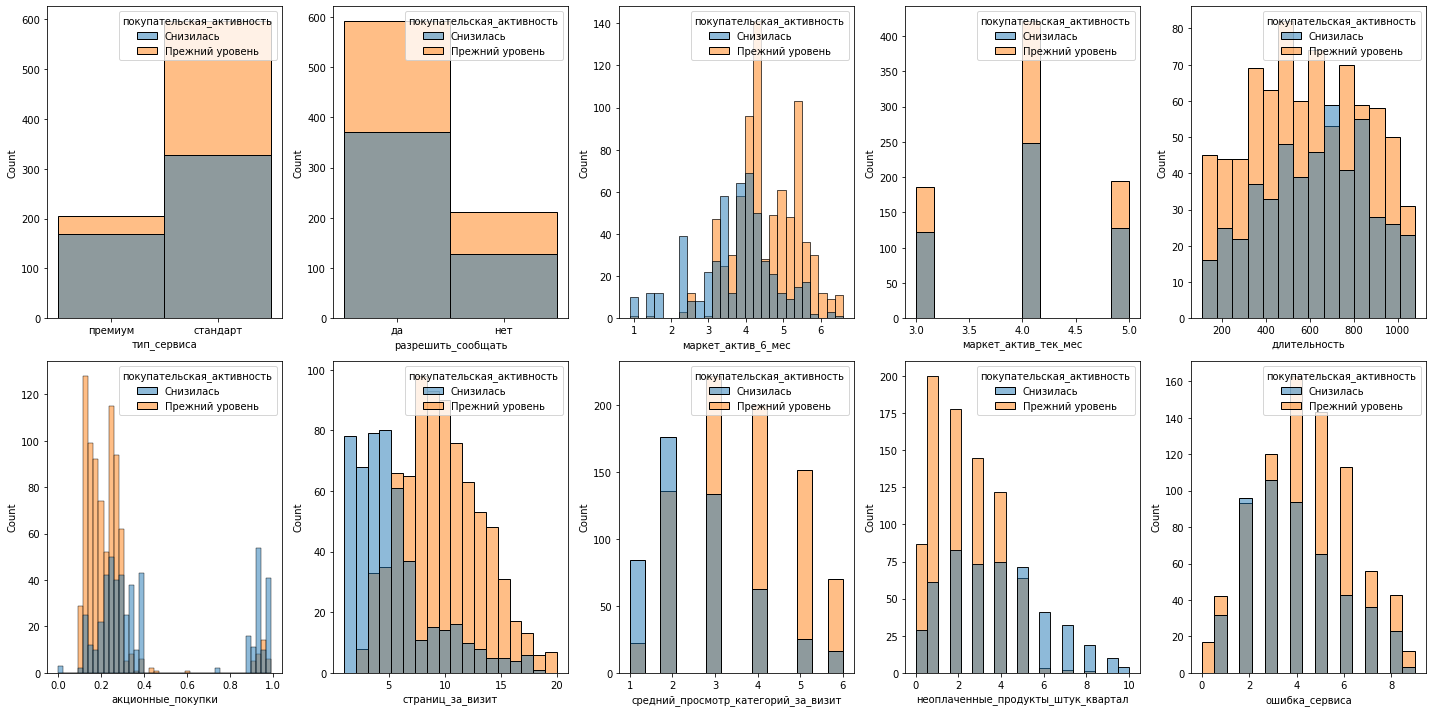

In [12]:
def graphik(data,x,hue,axes):
    sns.histplot(ax=axes,data=data,x=x,hue=hue)
features = [
    'тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес',
    'длительность', 'акционные_покупки', 'страниц_за_визит', 'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса'
]

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  

axes = axes.flatten()

for i, feature in enumerate(features):
    graphik(file, feature, 'покупательская_активность', axes[i])

plt.tight_layout() 
plt.show()

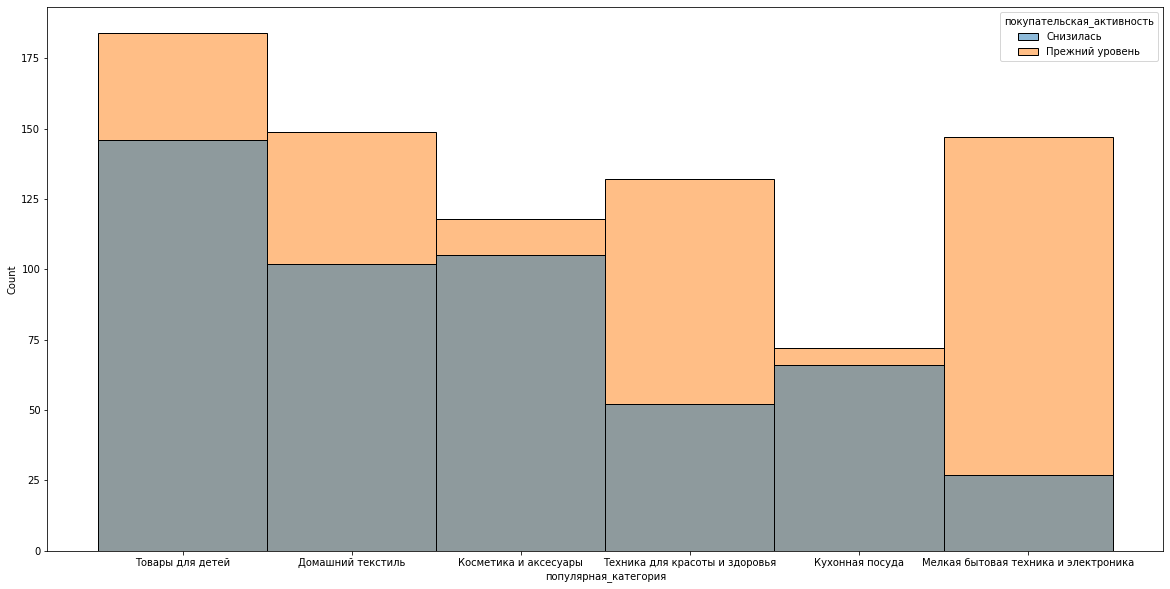

In [13]:
plt.figure(figsize=(20,10))
sns.histplot(data=file,x=file['популярная_категория'],hue=file['покупательская_активность'])
plt.show()

Глобально можно заметить, что люди со снизившейся покупательской активностью пролистывают меньше страниц, чем люди с прежней. Также, люди с прежней покупательской активностью реже покупают товары по акции и редко просматривают больше 3 категорий за визит. Более того, незаинтересованные клиенты гораздо чаще не оплачивают товары в корзине. Что касается популярных категорий, можно заметить, что категория Мелкая бытовая техника и электроника не пользуется популярностью у тех, чья покупательская активность снизилась, это может говорить о том, что эти люди не нашли на сайте того, что искали.

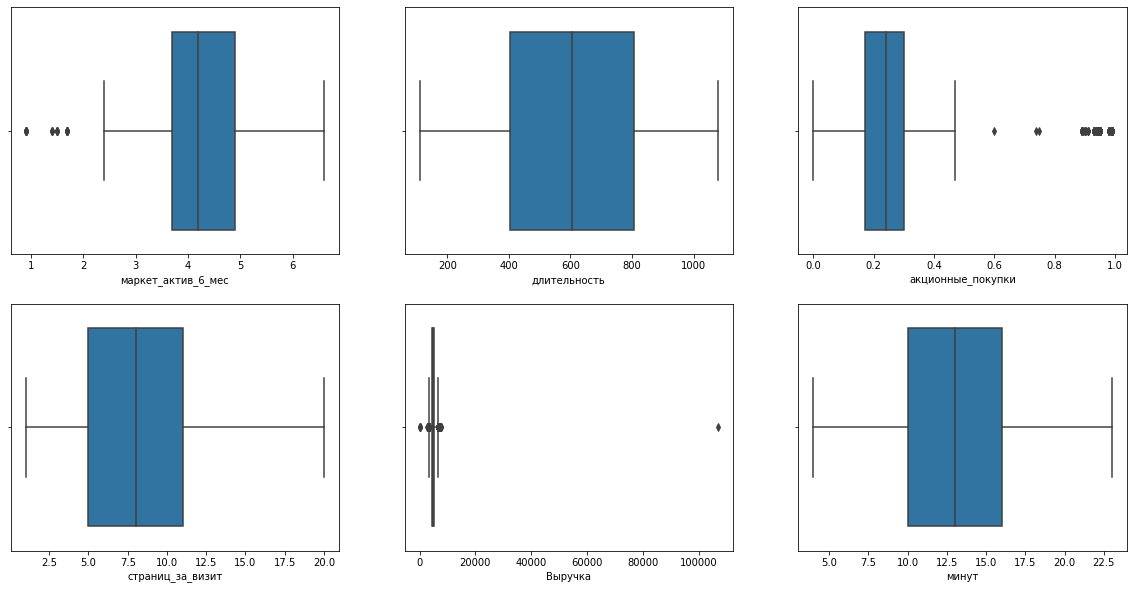

In [14]:
def graphikbox(data,x,axes):
    sns.boxplot(ax=axes,data=data,x=x)
fig, axes = plt.subplots(2,3, figsize=(20, 10))
graphikbox(file,file['маркет_актив_6_мес'],axes[0][0])
graphikbox(file,file['длительность'],axes[0][1])
graphikbox(file,file['акционные_покупки'],axes[0][2])
graphikbox(file,file['страниц_за_визит'],axes[1][0])
graphikbox(market_money,market_money['Выручка'],axes[1][1])
graphikbox(time,time['минут'],axes[1][2])

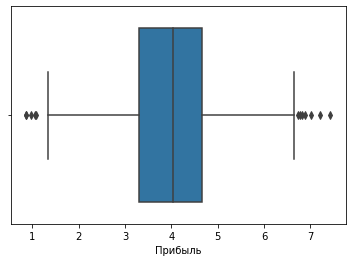

In [15]:
sns.boxplot(data=money,x=money['Прибыль'])
plt.show()

В датасете market_money обнаружен выброс, который следует удалить

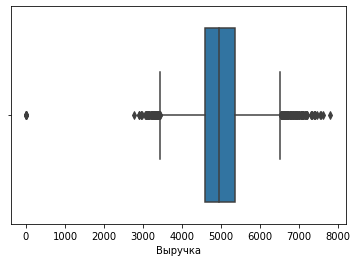

In [16]:
market_money=market_money[market_money['Выручка']<100000]
sns.boxplot(data=market_money,x=market_money['Выручка'])
plt.show()

## Объединение таблиц

In [17]:
market_money_prepred=market_money[market_money['Период']=='препредыдущий_месяц'].reset_index(drop=True)
market_money_pred=market_money[market_money['Период']=='предыдущий_месяц'].reset_index(drop=True)
market_money_this=market_money[market_money['Период']=='текущий_месяц'].reset_index(drop=True)
time_pred=time[time['Период']=='предыдущий_месяц'].reset_index(drop=True)
time_this=time[time['Период']=='текущий_месяц'].reset_index(drop=True)
file['выручка_за_препредыдущий_месяц']=market_money_prepred['Выручка']
file['выручка_за_предыдущий_месяц']=market_money_pred['Выручка']
file['выручка_за_текущий_месяц']=market_money_this['Выручка']
file['минут_за_предыдущий_месяц']=time_pred['минут']
file['минут_за_текущий_месяц']=time_this['минут']
file

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4704.0,3664.0,5353.0,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5299.0,4729.0,5139.2,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5334.0,5160.0,5224.6,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4725.0,4923.0,4448.3,18,7


Также необходимо убрать клиентов с нулевым количеством реальных покупок хотя бы за один из трех месяцев, потому что они не являются постоянными покупателями, для которых необходимо предсказать снижение или сохранение покупательской активности. Основная задача- предсказать сохранение покупательской активности постоянных клиентов, то есть тех, кто приобретает что-либо в магазине каждый месяц.

In [18]:
file=file.query('выручка_за_препредыдущий_месяц!=0&выручка_за_предыдущий_месяц!=0&выручка_за_текущий_месяц!=0')
file

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4704.0,3664.0,5353.0,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5299.0,4729.0,5139.2,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5334.0,5160.0,5224.6,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4725.0,4923.0,4448.3,18,7


## Корреляционный анализ

In [19]:
file=file.set_index('id')
file

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4704.0,3664.0,5353.0,14,7
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5299.0,4729.0,5139.2,12,11
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5334.0,5160.0,5224.6,12,18


Так как не все признаки распределены нормально, вместо корреляции Пирсона использую корреляцию phik.

<Axes: >

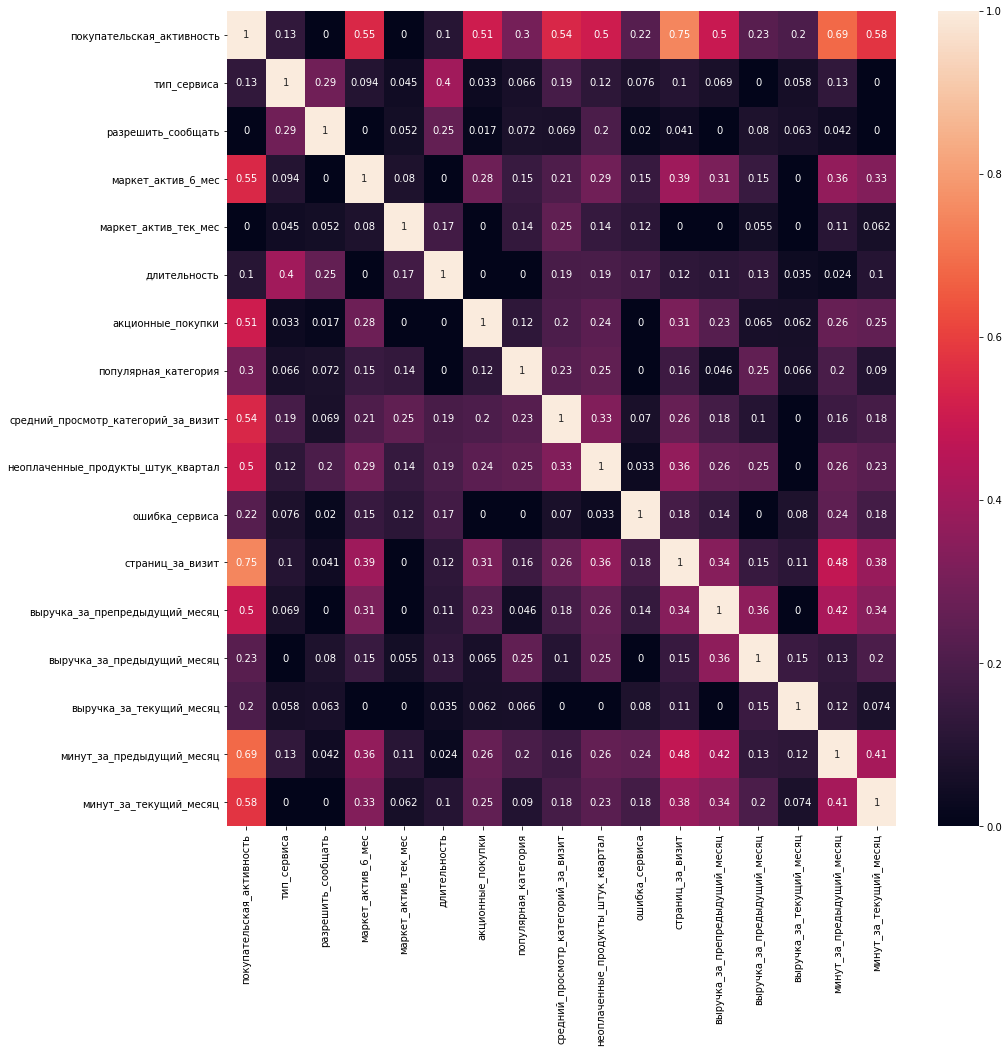

In [20]:
matrix=(file.phik_matrix(interval_cols=['маркет_актив_6_мес','маркет_актив_тек_мес','длительность','акционные_покупки','средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит','выручка_за_препредыдущий_месяц','выручка_за_предыдущий_месяц','выручка_за_текущий_месяц','минут_за_предыдущий_месяц','минут_за_текущий_месяц']))
plt.figure(figsize=(15,15))
sns.heatmap(matrix,annot=True)

Проанализировав корреляцию phik, можно заметить, что покупательская активность имеет умеренную корреляцию с акционными покупками, количеством маркетинговых коммуникаций за последние 6 месяцев, средним просмотром категорий за визит, неоплаченными продуктами, а также высокую корреляцию с количеством страниц, посещенных за визит и количеством минут, проведенных на сервисе.

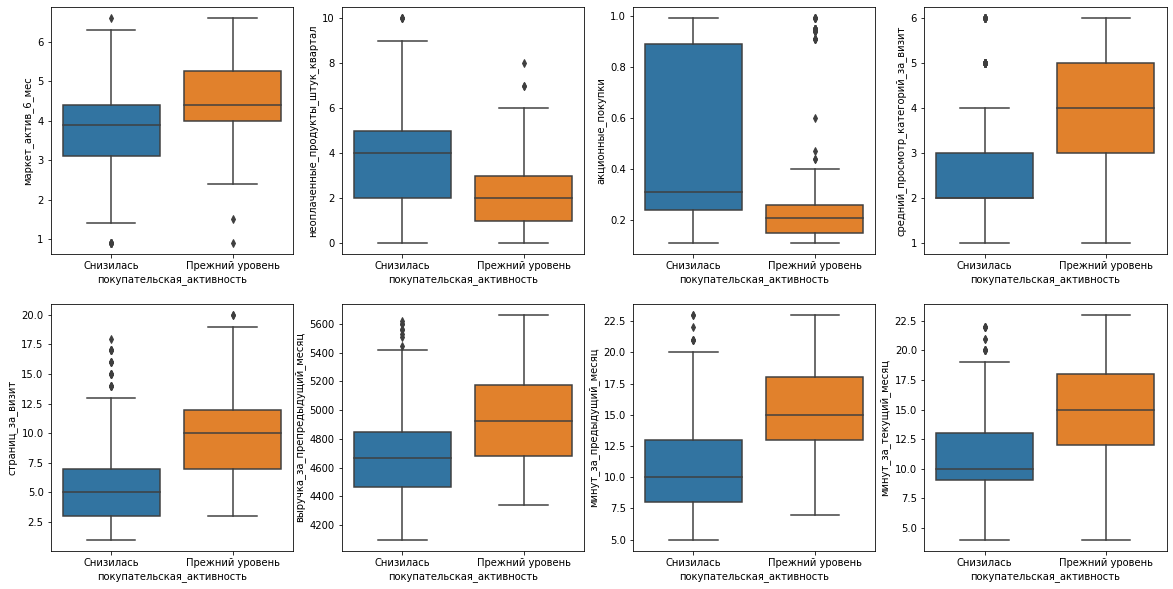

In [21]:
fig, axes = plt.subplots(2,4, figsize=(20, 10))
sns.boxplot(x=file['покупательская_активность'], y=file['маркет_актив_6_мес'], data=file,ax=axes[0][0])
sns.boxplot(x=file['покупательская_активность'], y=file['неоплаченные_продукты_штук_квартал'], data=file,ax=axes[0][1])
sns.boxplot(x=file['покупательская_активность'], y=file['акционные_покупки'], data=file,ax=axes[0][2])
sns.boxplot(x=file['покупательская_активность'], y=file['средний_просмотр_категорий_за_визит'], data=file,ax=axes[0][3])
sns.boxplot(x=file['покупательская_активность'], y=file['страниц_за_визит'], data=file,ax=axes[1][0])
sns.boxplot(x=file['покупательская_активность'], y=file['выручка_за_препредыдущий_месяц'], data=file,ax=axes[1][1])
sns.boxplot(x=file['покупательская_активность'], y=file['минут_за_предыдущий_месяц'], data=file,ax=axes[1][2])
sns.boxplot(x=file['покупательская_активность'], y=file['минут_за_текущий_месяц'], data=file,ax=axes[1][3])
plt.show()

Можно заметить, что люди, у которых покупательская активность осталась на прежнем уровне, редко не оплачивают товары(в среднем 2-4 товара), в то время как те, кто меньше заинтересован в покупках на сайте, достаточно часто добавляют товары и не оплачивают их. Возможно им просто не хватает средств, чтобы приобрести их в данном магазине, поэтому они добавляют товары в корзину, чтобы не забыть о них.

Зависимость между покупательской активностью и акционными покупками не совсем похожа на линейную: большая часть покупателей имеет долю акционных покупок 10-40%, однако также много и тех, чья доля акционных покупок близка к 100%, при этом их покупательская активность снизилась- это может означать, что эти клиенты перестали покупать что либо по обычной цене в ожидании скидок и акций.

Между количеством маркетинговых коммуникаций и покупательской активностью наблюдается линейная зависимость: у клиентов, чья покупательская активность осталась на прежнем уровне, это значение составляет 3-6, людей со снизившейся покупательской активностью тревожат звонками реже- в среднем от 2 до 5%.

Между страницами, посещенными за визит и покупательской активностью тоже существует линейная зависимость: покупатели с прежней покупательской активностью посещают около 7-15 страниц за визит, а клиентов со снизившейся активностью становится меньше по мере возрастания количества страниц. Это логично, поскольку интерес этих пользователей к магазину пропадает, вряд ли они станут просматривать другие товары в этом магазине.

Покупательская активность также линейно связана с просмотром категорий за визит: при прежнем уровне активности клиенты изучают 3-5 разных категорий, очень мало тех, кто просматривает 1-2 категории, среди менее заинтересованных ситуация противоположна: клиенты интересуются 2-3 разными категориями, 4-6 категорий просматривает значительно меньше людей.

Покупательская активность и время, проведенное на сайте, тоже связаны линейно- очевидно, что те, кто планирует совершать покупки в будущем на этом сайте, будут проводить больше времени в интерфейсе магазина- 10-20 минут, нежели те, кто больше не так нуждается в товарах магазина- такие люди проводят на сайте 7-12 минут, и с увеличением времени,число незаинтересованных клиентов падает.

В целом, можно сделать вывод, что почти все заметно коррелирующие признаки с целевым имеют линейную зависимость, кроме акционных покупок, здесь речь может идти о кластеризации, так как достаточно много клиентов приобретают товары только при наличии акций на эти товары.

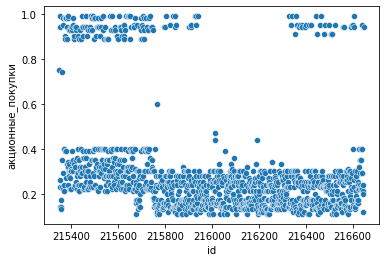

In [22]:
sns.scatterplot(data=file,x='id', y='акционные_покупки')
plt.show()

Здесь можно заметить кластеризацию, поскольку можно увидеть два облака точек: с долей акционных покупок близкой к 1 и с долей 0.2-0.4. Скорее всего так происходит, потому что некоторые покупатели ждут скидок в магазине, приобретая товары только после появления акций на них. Также для определённых id (Посередине),  доля акционных продаж очень низкая (Дырка в точках от 0,8 до 1)

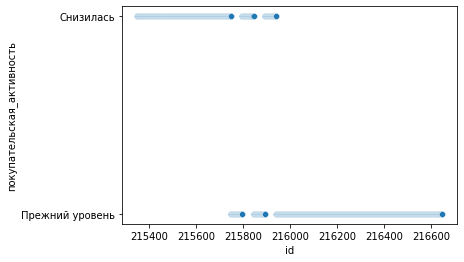

In [23]:
sns.scatterplot(data=file,x='id', y='покупательская_активность')
plt.show()

id в таблице относительно упорядочены: сначала идут все пользователи со снизившейся покупательской активностью, затем они поочередно меняются с пользователями с прежним таргетом, а затем идут id только тех, чья активность не изменилась

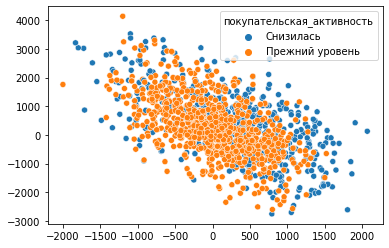

In [24]:
sns.scatterplot(data=file,x=file['выручка_за_предыдущий_месяц']-file['выручка_за_препредыдущий_месяц'], y=file['выручка_за_текущий_месяц']-file['выручка_за_предыдущий_месяц'],hue='покупательская_активность')
plt.show()

Чем больше потратил покупатель в предыдущем месяце, тем больше будет по модулю разность с препредыдущим месяцем и с текущим соответственно. В принципе логично. Зарплата обычно фиксированные, поэтому если в 1 месяц клиент позволил себе потратить чуть больше, в следующий месяц ему приходится ужиматься


## Использование пайплайнов

Закодирую целевой признак

In [25]:
file["покупательская_активность"] = file["покупательская_активность"].replace(to_replace='Прежний уровень',value=0)
file["покупательская_активность"] = file["покупательская_активность"].replace(to_replace='Снизилась',value=1)

In [26]:
TEST_SIZE = 0.25
file=file.dropna()
RANDOM_STATE=42
X_train, X_test, y_train, y_test = train_test_split(
    file.drop(
        ['покупательская_активность'], 
        axis=1
    ),
    file['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = file['покупательская_активность']
)

In [27]:

ohe_columns=['тип_сервиса','разрешить_сообщать','популярная_категория']
num_columns=['маркет_актив_6_мес','маркет_актив_тек_мес','длительность',
             'акционные_покупки','средний_просмотр_категорий_за_визит',
             'неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит',
             'выручка_за_препредыдущий_месяц','выручка_за_предыдущий_месяц','выручка_за_текущий_месяц',
             'минут_за_предыдущий_месяц','минут_за_текущий_месяц']
ohe_pipe = Pipeline([
        ('ohe',OneHotEncoder(drop='first',handle_unknown='ignore'))])
preprocessing=ColumnTransformer([
    ('ohe',ohe_pipe,ohe_columns),
    ('num',MinMaxScaler(),num_columns)
],remainder='passthrough')
pipe_final=Pipeline([
    ('preprocessor',preprocessing),
    ('models',DecisionTreeClassifier(random_state=RANDOM_STATE))
])
param_distributions=[{
    'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
    'preprocessor__num':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'models__max_depth':range(1,20),
},
{
    'models':[KNeighborsClassifier()],
    'preprocessor__num':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'models__n_neighbors':range(1,20)
},
{
    'models':[LogisticRegression(random_state=RANDOM_STATE)],
    'models__C':range(1,10),
    'preprocessor__num':[StandardScaler(),MinMaxScaler(),'passthrough']
},
{
    'models':[SVC(random_state=RANDOM_STATE)],
    'models__C':range(1,5),
    'preprocessor__num':[StandardScaler(),MinMaxScaler(),'passthrough']
}]
grid=RandomizedSearchCV(
    pipe_final,
    param_distributions,
    cv=5,
    scoring=['roc_auc', 'accuracy', 'recall'],
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=3,
    refit='recall'
)
grid.fit(X_train, y_train) 
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_) 
print ('Метрика лучшей модели на кросс-валидационной выборке:', grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END models=KNeighborsClassifier(), models__n_neighbors=10, preprocessor__num=StandardScaler(); accuracy: (test=0.882) recall: (test=0.743) roc_auc: (test=0.904) total time=   0.3s
[CV 2/5] END models=KNeighborsClassifier(), models__n_neighbors=10, preprocessor__num=StandardScaler(); accuracy: (test=0.882) recall: (test=0.720) roc_auc: (test=0.885) total time=   0.1s
[CV 3/5] END models=KNeighborsClassifier(), models__n_neighbors=10, preprocessor__num=StandardScaler(); accuracy: (test=0.902) recall: (test=0.770) roc_auc: (test=0.943) total time=   0.0s
[CV 4/5] END models=KNeighborsClassifier(), models__n_neighbors=10, preprocessor__num=StandardScaler(); accuracy: (test=0.881) recall: (test=0.703) roc_auc: (test=0.913) total time=   0.1s
[CV 5/5] END models=KNeighborsClassifier(), models__n_neighbors=10, preprocessor__num=StandardScaler(); accuracy: (test=0.830) recall: (test=0.689) roc_auc: (test=0.860) total time=  

В данном случае нам необходимо найти всех потенциальных покупателей, чья покупательская активность может снизиться. Поэтому необходимо найти как можно больше положительных объектов, так как, если мы определим обычного пользователя как вероятно теряющего интерес, ничего страшного не произойдет. Поэтому необходима метрика recall

In [28]:
y_test_pred = grid.predict(X_test)
print(f'Метрика Recall на тестовой выборке: {recall_score(y_test, y_test_pred)}')

Метрика Recall на тестовой выборке: 0.8225806451612904


## Анализ важности признаков

In [29]:
X_train_shap = pd.DataFrame(pipe_final.named_steps['preprocessor'].fit_transform(X_train), 
                            columns=pipe_final.named_steps['preprocessor'].get_feature_names_out())

X_test_shap = pd.DataFrame(pipe_final.named_steps['preprocessor'].transform(X_test), 
                           columns=pipe_final.named_steps['preprocessor'].get_feature_names_out())

explainer = shap.KernelExplainer(grid.best_estimator_.named_steps['models'].predict_proba, X_train_shap[:100])
shap_values = explainer(X_test_shap[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

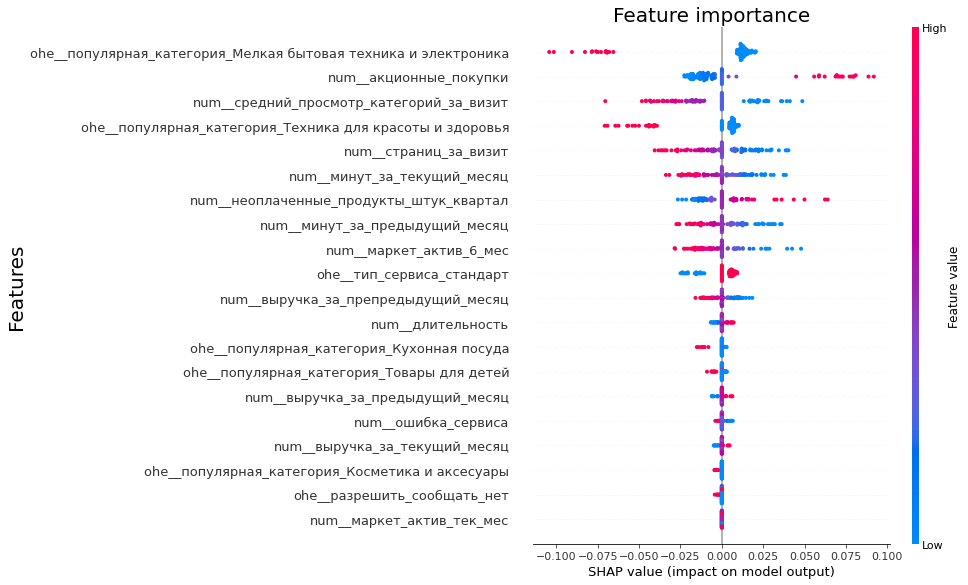

In [30]:
fig, ax = plt.gcf(), plt.gca()
ax.set_title('Feature importance',fontsize=20)
ax.set_ylabel('Features',fontsize=20)
columns=grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out() 
try:
    shap_values.feature_names=columns
except:
    explainer.data_feature_names=columns
shap.plots.beeswarm(shap_values[:, :, 1], max_display=25)


Клиент с популярной категорией Мелкая бытовая техника и электроника вероятнее всего не снизит свою покупательскую активность согласно модели.
    
Высокое значение просмотренных категорий за визит также хороший знак, который говорит о том, что клиенты вряд ли снизят активность в будущем. Это логично, ведь чем реже ты просматриваешь категории, тем меньше ты в целом заинтересован в товарах магазина
    
А вот высокое значение акционных покупок наоборот говорит о том, что клиент скорее всего снизит активность в будущем, что тоже не лишено смысла, такие люди заходят на сайт в ожидании скидок и не планируют покупать товары на постоянной основе
    
Страницы за визит тоже влияют на вердикт модели:так, чем больше страниц листает клиент тем увереннее можно быть в его покупательской активности и наоборот, уменьшение кол-ва страниц, просмотренных пользователем- это звоночек, что скоро активность снизится
    
То же самое можно сказать про минуты в текущем и предыдущем месяце
    
Категория Техника для красоты и здоровья тоже является достаточно надежной, ведь клиенты, у которых любимая категория- эта, скорее всего сохранят покупательскую активность
    
Высокое значение маркетинговых коммуникаций с клиентом- это хороший знак того, что пользователь останется активным, а низкое значение может говорить о потенциальном снижении

## Сегментация покупателей

Начну рассматривать сегмент клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью для того, чтобы сохранить самых выгодных клиентов
 

In [31]:
file_copy=file
file_copy=file_copy.drop(columns='покупательская_активность')
file_copy_wow=pipe_final.named_steps['preprocessor'].fit_transform(file_copy)
an=grid.best_estimator_.named_steps['models'].predict_proba(file_copy_wow)
file_copy['вероятность_снижения_активности']=an[:,1].round(3)
money=money.set_index('id')
file_copy=file_copy.join(money)
moo=file_copy.query('вероятность_снижения_активности>0.3&Прибыль>5')
moo

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,вероятность_снижения_активности,Прибыль
id,,,,,,,,,,,,,,,,,,
215388,стандарт,да,3.5,4,663,0.99,Домашний текстиль,4,2,2,2,4182.0,3188.0,4429.1,10,12,0.360,5.16
215396,стандарт,да,3.4,5,706,0.22,Домашний текстиль,2,3,8,4,4805.0,5876.0,5040.2,12,6,0.301,5.09
215400,стандарт,нет,4.4,5,304,0.94,Товары для детей,1,4,3,2,4439.0,5681.0,6065.9,11,9,0.447,6.73
215425,стандарт,да,4.1,4,249,0.28,Кухонная посуда,2,6,1,4,4623.0,5202.0,6150.2,10,11,0.309,5.64
215456,стандарт,да,1.7,4,449,0.23,Косметика и аксесуары,3,4,4,5,4353.0,5134.5,5805.0,10,9,0.315,5.83
215459,премиум,да,4.1,4,768,0.94,Кухонная посуда,2,8,7,6,4119.0,4782.0,6063.4,14,8,0.394,5.16
215485,стандарт,да,3.5,4,720,0.99,Косметика и аксесуары,1,2,4,7,4234.0,4201.0,4517.0,10,14,0.392,5.41
215494,стандарт,нет,5.6,5,372,0.23,Косметика и аксесуары,1,6,2,3,4502.0,5258.0,4369.7,9,13,0.304,6.12
215503,стандарт,да,2.4,5,638,0.24,Домашний текстиль,1,5,2,1,4119.0,5046.0,3412.5,7,8,0.450,5.23


Судя по категориям Товары для детей и Косметика и аксессуары- самые прибыльные клиентки- это женщины-мамы. Почти все они пользуются стандартным сервисом и редко просматривают больше 2 категорий, и в среднем не оплачивают 2-4 товара, пролистывая не так много страниц за визит.

Также посмотрю на динамику выручки по месяцам, в группировке по категориальным признакам (популярная категория Товаров)

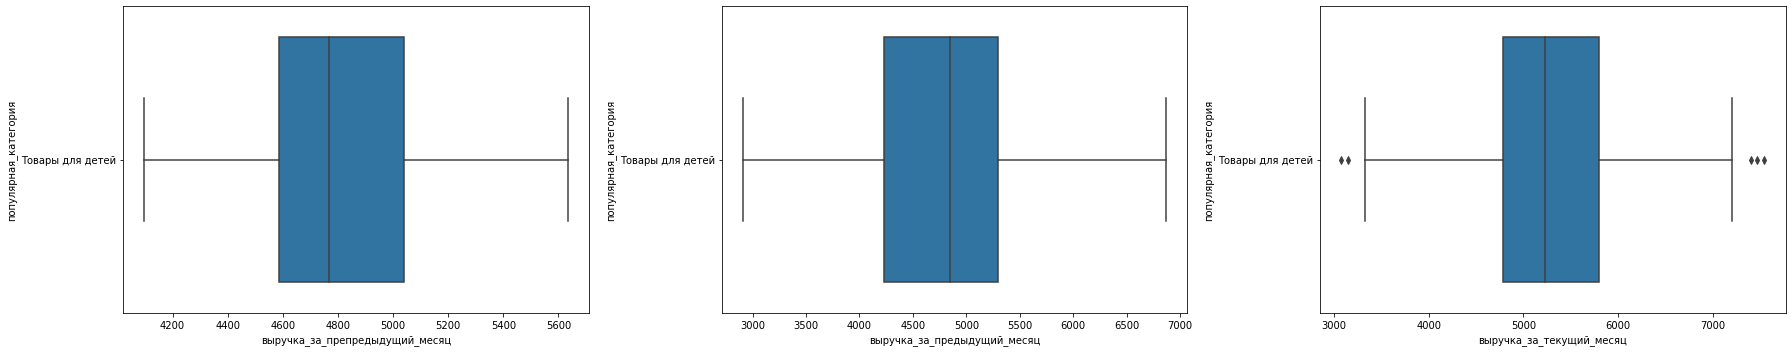

In [32]:
kateg=['выручка_за_препредыдущий_месяц','выручка_за_предыдущий_месяц','выручка_за_текущий_месяц']
fig, axes = plt.subplots(1,3, figsize=(25, 5))
axes = axes.flatten()
for i,feature in enumerate(kateg):
    sns.boxplot(data=file[file['популярная_категория']=='Товары для детей'],x=feature,y='популярная_категория',ax=axes[i])
plt.tight_layout() 
plt.show()

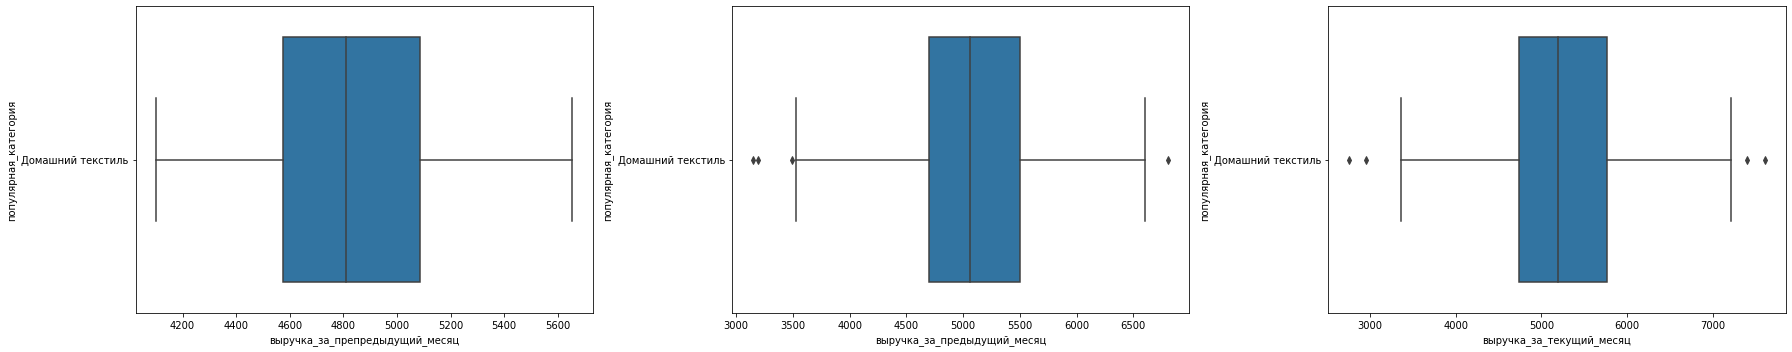

In [33]:
fig, axes = plt.subplots(1,3, figsize=(25, 5))
axes = axes.flatten()
for i,feature in enumerate(kateg):
    sns.boxplot(data=file[file['популярная_категория']=='Домашний текстиль'],x=feature,y='популярная_категория',ax=axes[i])
plt.tight_layout() 
plt.show()

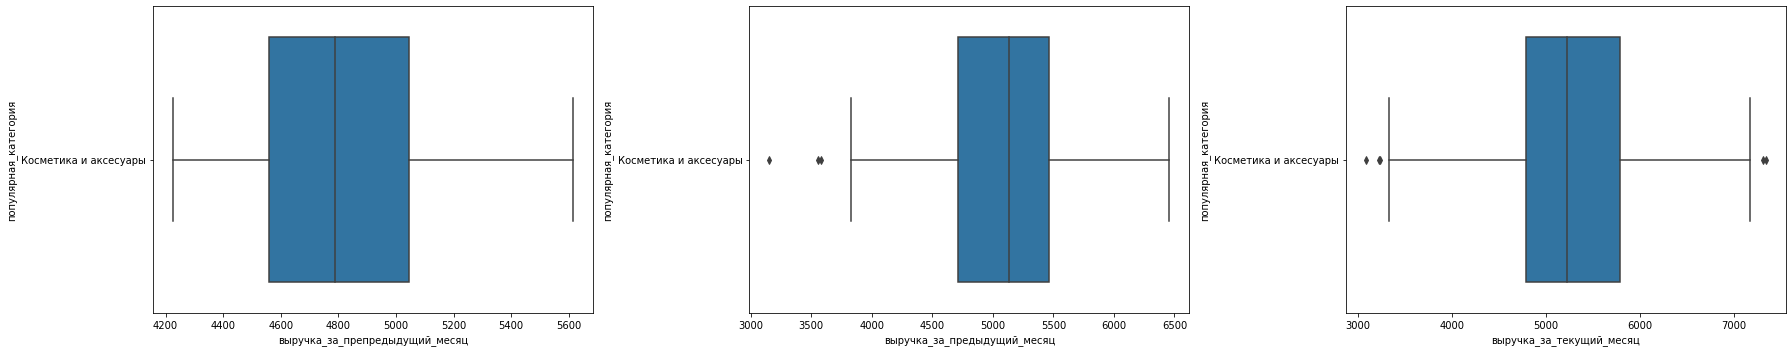

In [34]:
fig, axes = plt.subplots(1,3, figsize=(25, 5))
axes = axes.flatten()
for i,feature in enumerate(kateg):
    sns.boxplot(data=file[file['популярная_категория']=='Косметика и аксесуары'],x=feature,y='популярная_категория',ax=axes[i])
plt.tight_layout() 
plt.show()

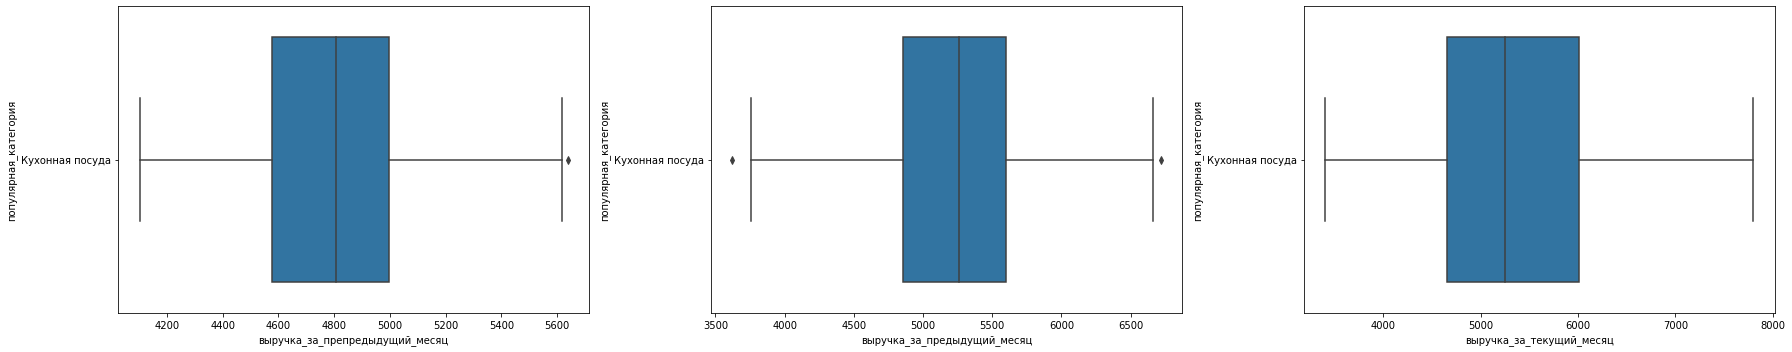

In [35]:
fig, axes = plt.subplots(1,3, figsize=(25, 5))
axes = axes.flatten()
for i,feature in enumerate(kateg):
    sns.boxplot(data=file[file['популярная_категория']=='Кухонная посуда'],x=feature,y='популярная_категория',ax=axes[i])
plt.tight_layout() 
plt.show()

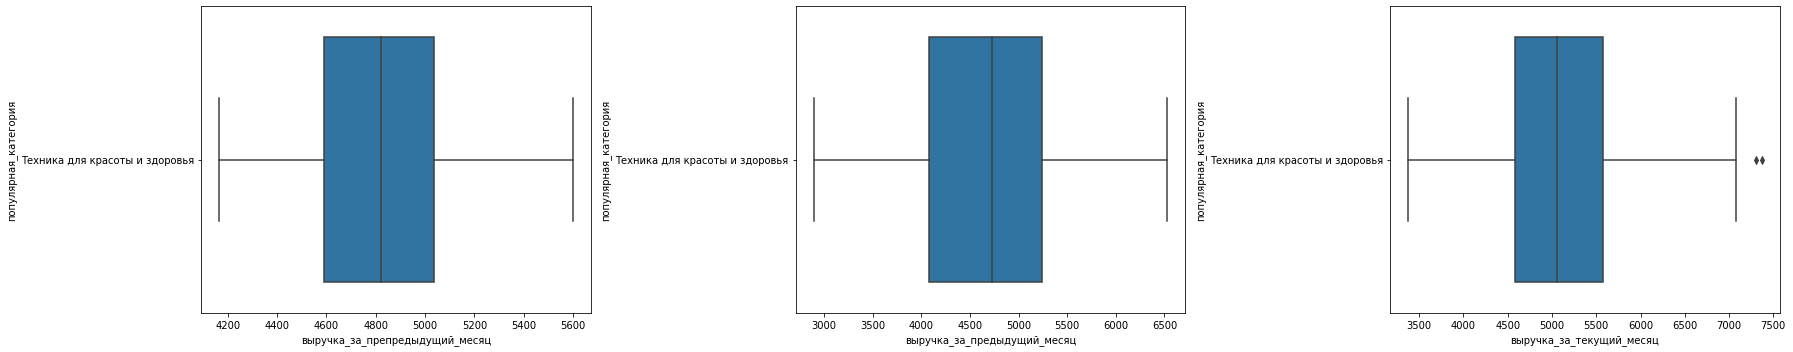

In [36]:
fig, axes = plt.subplots(1,3, figsize=(25, 5))
axes = axes.flatten()
for i,feature in enumerate(kateg):
    sns.boxplot(data=file[file['популярная_категория']=='Техника для красоты и здоровья'],x=feature,y='популярная_категория',ax=axes[i])
plt.tight_layout() 
plt.show()

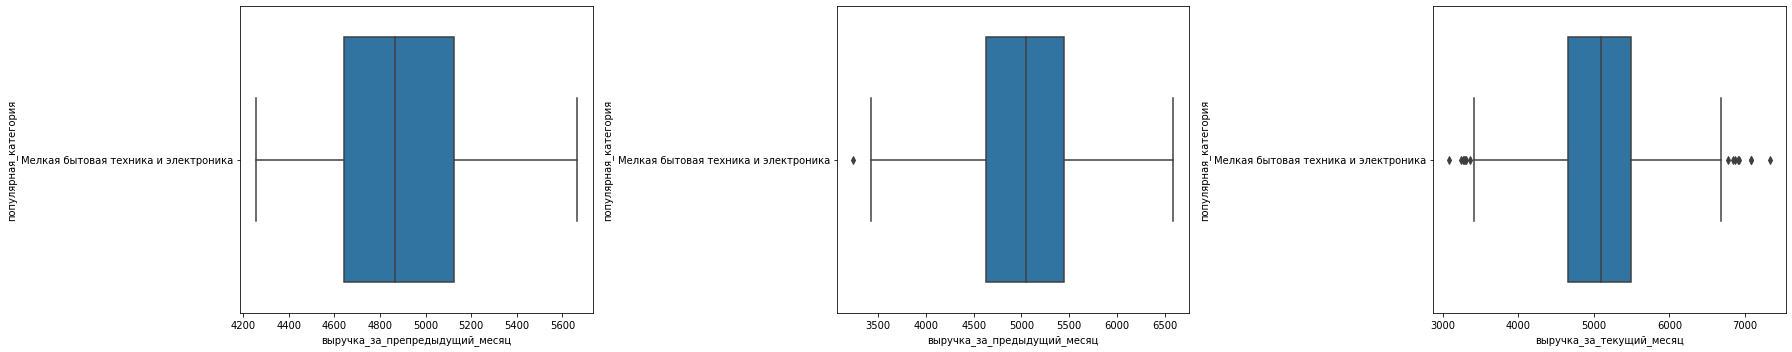

In [37]:
fig, axes = plt.subplots(1,3, figsize=(25, 5))
axes = axes.flatten()
for i,feature in enumerate(kateg):
    sns.boxplot(data=file[file['популярная_категория']=='Мелкая бытовая техника и электроника'],x=feature,y='популярная_категория',ax=axes[i])
plt.tight_layout() 
plt.show()

Техника для красоты и здоровья приносит сильно меньше выручки по сравнению с остальными.

Касательно предложений: самым прибыльным и рискованным сегментом остаются женщины-мамы, ищущие товары для детей и косметику с аксессуарами. Можно попробовать предложить им товары из категории Техника для красоты и здоровья, ведь если они интересуются косметикой, значит озабочены своей внешностью, и что-то из этой категории может и их привлечь.

## Общий вывод

Необходимо было спрогнозировать вероятность снижения покупательской активности и разработать персонализированные предложения одному из сегментов покупателей.

Всего в датасете было 1300 строк и 18 столбцов. Для предобработки данных я убедился в отсутствии пропусков и дубликатов, поправил некоторые значения, после чего я создал пайплайн с кодировщиком: OneHotEncoder для того, чтобы закодировать имеющиеся категориальные признаки. Затем для поиска лучшей модели я сделал один большой пайплайн, в котором перебирал модели и гиперпараметры к ним, среди которых был также перебор скейлеров:StandardScaler и MinMaxScaler. Лучшей моделью получилась модель LogistiRegression с гиперпараметром c=1 c метрикой 0.76. На тестовой метрике модель достигла 0.82

Что касается покупателей, которые покупают только технику, можно посоветовать добавить скидок на товары из категории Техника для красоты и здоровья и Мелкая бытовая техника и электроника, поскольку люди из этого сегмента достаточно часто совершают покупки по акции. Также можно предлагать по акции второй товар из этой же категории со скидкой